In [36]:
# GNN and Tabular Transformer (Address-level)
# Single-file notebook-style script using cell separators (for Jupyter/VSCode: Run cells)
# This version is tailored for the provided file: /mnt/data/ethereum_raw.csv
# It assumes the file is already address-level with columns: 'Address' (ID) and 'FLAG' (label).
# The notebook will: load data, preprocess, build a KNN similarity graph for GNN, train a node-classifier GNN and a Tabular Transformer, evaluate and save artifacts.


In [37]:
# 1) Setup & imports
import os
import random
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, precision_recall_fscore_support, accuracy_score
from sklearn.neighbors import NearestNeighbors

# For GNN
try:
    import torch_geometric
    from torch_geometric.data import Data
    from torch_geometric.nn import SAGEConv
except Exception as e:
    print("torch_geometric not installed or import failed:", e)

# For baseline
try:
    import lightgbm as lgb
except Exception:
    lgb = None

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_PATH = 'E:/Projects/CBK_Assignment/Greenland_Registry/ethereum_raw.csv'
ARTIFACTS_DIR = './artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

os.makedirs(ARTIFACTS_DIR, exist_ok=True)


In [38]:
# 2) Load CSV & quick EDA
print('Loading', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Rows, cols:', df.shape)
print(df.columns.tolist())
print(df.head(3))


Loading E:/Projects/CBK_Assignment/Greenland_Registry/ethereum_raw.csv
Rows, cols: (9841, 51)
['Unnamed: 0', 'Index', 'Address', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between 

In [39]:
# 3) Sanity: confirm ID and label columns and prepare feature DataFrame
ID_COL = 'Address'
LABEL_COL = 'FLAG'
if ID_COL not in df.columns or LABEL_COL not in df.columns:
    raise ValueError(f"Expected columns '{ID_COL}' and '{LABEL_COL}' in CSV. Found: {df.columns.tolist()}")

# Drop obvious index-like columns if present
drop_like = [c for c in ['Unnamed: 0', 'Index', 'index'] if c in df.columns]
if drop_like:
    df = df.drop(columns=drop_like)

# Make sure Address is string and FLAG is integer 0/1
df[ID_COL] = df[ID_COL].astype(str)
# FLAG may be numeric or string; coerce to int
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors='coerce').fillna(0).astype(int)

# Build features: exclude ID and label, drop columns with too many unique strings
# Build features: exclude ID and label, only drop obvious index-like columns
raw_features = [c for c in df.columns if c not in [ID_COL, LABEL_COL]]
print('Initial feature columns count:', len(raw_features))

# Drop index-like columns (we already did earlier for df), but ensure they are not used as features
drop_like = [c for c in ['Unnamed: 0', 'Index', 'index'] if c in raw_features]
if drop_like:
    print('Removing index-like columns from features:', drop_like)
    raw_features = [c for c in raw_features if c not in drop_like]

# Separate numeric and categorical heuristically
numeric_cols = [c for c in raw_features if pd.api.types.is_numeric_dtype(df[c])]
categorical_cols = [c for c in raw_features if c not in numeric_cols]

print('Numeric cols count:', len(numeric_cols), 'Categorical cols count:', len(categorical_cols))

# IMPORTANT: We will KEEP all features (no further dropping).
# Encode ALL categorical columns with LabelEncoder (note: high-cardinality categories will produce large integer labels)
cat_encoders = {}
for c in categorical_cols:
    le = LabelEncoder()
    # convert to string and fill NAs so LabelEncoder works reliably
    df[c] = df[c].fillna('NA').astype(str)
    df[c] = le.fit_transform(df[c])
    cat_encoders[c] = le

# Final feature set: numeric columns (unchanged) + encoded categorical columns
features = numeric_cols + categorical_cols
print('Using features count:', len(features))
feature_df = df[features].copy()

# Ensure numeric columns are numeric and fill NAs
for c in numeric_cols:
    feature_df[c] = pd.to_numeric(feature_df[c], errors='coerce').fillna(0.0)

# At this point categorical columns are integer-coded by LabelEncoder; safe to convert to float for scaling
feature_df[categorical_cols] = feature_df[categorical_cols].astype(float)

# Final numpy arrays for tabular model
X = feature_df.values.astype(float)
y = df[LABEL_COL].values.astype(int)
addresses = df[ID_COL].values.astype(str)

print("✅ Columns used for model training/testing:")
print(feature_df.columns.tolist())
print(f"Total features used: {len(feature_df.columns)}")

# Optionally save the list to a text file
with open(os.path.join(ARTIFACTS_DIR, 'used_features.txt'), 'w') as f:
    for c in feature_df.columns:
        f.write(c + '\n')

# Scale numeric features (we scale the whole matrix; encoded categories are also scaled)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Save preproc artifacts
with open(os.path.join(ARTIFACTS_DIR, 'tab_preproc.pkl'), 'wb') as f:
    pickle.dump({
        'features': features,
        'numeric_cols': numeric_cols,
        'categorical_cols': categorical_cols,
        'cat_encoders': cat_encoders,
        'scaler': scaler
    }, f)

np.save(os.path.join(ARTIFACTS_DIR, 'X.npy'), X)
np.save(os.path.join(ARTIFACTS_DIR, 'y.npy'), y)
np.save(os.path.join(ARTIFACTS_DIR, 'addresses.npy'), addresses)
print('Saved tabular artifacts. Feature count:', X.shape[1])



Initial feature columns count: 47
Numeric cols count: 45 Categorical cols count: 2
Using features count: 47
✅ Columns used for model training/testing:
['Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 av

In [40]:
# 4) Build KNN graph from feature similarity (for GNN node classification)
# We'll build an undirected kNN graph where each node connects to its k nearest neighbours
K = 10
print('Building kNN graph with k=', K)
knn = NearestNeighbors(n_neighbors=min(K+1, X.shape[0]), metric='cosine', n_jobs=-1).fit(X)  # +1 because first neighbor is itself
dists, neigh = knn.kneighbors(X, return_distance=True)
# build edge list
rows = []
cols = []
N = X.shape[0]
for i in range(N):
    # ensure we don't exceed neighbors
    neighbors = neigh[i, 1: min(K+1, neigh.shape[1])]
    for j in neighbors:
        rows.append(i)
        cols.append(int(j))
# undirected: add reverse edges
edge_index = torch.tensor([rows + cols, cols + rows], dtype=torch.long)

# node features as torch tensor
x_nodes = torch.tensor(X, dtype=torch.float)
# node labels
y_nodes = torch.tensor(y, dtype=torch.long)

torch.save({'edge_index': edge_index, 'x': x_nodes, 'y': y_nodes, 'addresses': addresses}, os.path.join(ARTIFACTS_DIR, 'graph_artifacts.pt'))
print('Saved graph artifacts. Nodes:', N, 'Edges:', edge_index.shape[1])


Building kNN graph with k= 10
Saved graph artifacts. Nodes: 9841 Edges: 196820


In [41]:
# 5) Baseline LightGBM (optional) — expanded metrics for direct comparison
if lgb is not None:
    # stratified split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_test, label=y_test, reference=dtrain)

    params = {'objective':'binary', 'metric':'auc', 'verbosity':-1}
    bst = lgb.train(
    params,
    dtrain,
    valid_sets=[dval],
    num_boost_round=200,
    callbacks=[lgb.early_stopping(stopping_rounds=20)]
)

    # Predict probabilities and binary labels (threshold 0.5)
    probs = bst.predict(X_test)
    preds = (probs > 0.5).astype(int)

    # Metrics
    auc_score = roc_auc_score(y_test, probs) if len(np.unique(y_test)) > 1 else float('nan')
    pr, rc, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(rc, pr)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary', zero_division=0)
    acc = accuracy_score(y_test, preds)

    # Print in the same style as other models
    print(f"LightGBM TEST auc: {auc_score:.6f} prec: {prec:.6f} rec: {rec:.6f} f1: {f1:.6f} acc: {acc:.6f} PR-AUC: {pr_auc:.6f}")

    # Save model and predictions for later analysis
    bst.save_model(os.path.join(ARTIFACTS_DIR, 'lgb_baseline.txt'))
    np.save(os.path.join(ARTIFACTS_DIR, 'lgb_test_probs.npy'), probs)
    np.save(os.path.join(ARTIFACTS_DIR, 'lgb_test_preds.npy'), preds)
    np.save(os.path.join(ARTIFACTS_DIR, 'lgb_test_true.npy'), y_test)
else:
    print('lightgbm not installed; skipping baseline')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.999382
LightGBM TEST auc: 0.999382 prec: 1.000000 rec: 0.972477 f1: 0.986047 acc: 0.993906 PR-AUC: 0.998283


In [42]:
# 6) GNN (node classification) training & evaluation using GraphSAGE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
art = torch.load(os.path.join(ARTIFACTS_DIR, 'graph_artifacts.pt'))
edge_index = art['edge_index'].to(device)
x_nodes = art['x'].to(device)
y_nodes = art['y'].to(device)

# simple train/val/test split on nodes (stratified)
idx = np.arange(x_nodes.shape[0])
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=SEED, stratify=y_nodes.cpu().numpy())
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=SEED, stratify=y_nodes.cpu().numpy()[train_idx])

class NodeGNN(nn.Module):
    def __init__(self, in_ch, hidden=128, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_ch, hidden))
        for _ in range(num_layers-1):
            self.convs.append(SAGEConv(hidden, hidden))
        self.head = nn.Linear(hidden, 1)  # single logit for binary
    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        return self.head(x).squeeze(-1)

model = NodeGNN(in_ch=x_nodes.shape[1], hidden=128, num_layers=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# handle class imbalance via pos_weight
pos_weight = (y_nodes==0).sum().float() / (y_nodes==1).sum().float() if (y_nodes==1).sum()>0 else torch.tensor(1.0)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

for epoch in range(1, 101):
    model.train()
    opt.zero_grad()
    logits = model(x_nodes, edge_index)
    loss = loss_fn(logits[train_idx], y_nodes[train_idx].float())
    loss.backward()
    opt.step()
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            val_logits = torch.sigmoid(logits[val_idx]).cpu().numpy()
            val_pred = (val_logits > 0.5).astype(int)
            val_true = y_nodes[val_idx].cpu().numpy().astype(int)
            try:
                auc_val = roc_auc_score(val_true, val_logits)
            except Exception:
                auc_val = float('nan')
            prec, rec, f1, _ = precision_recall_fscore_support(val_true, val_pred, average='binary', zero_division=0)
        print(f'Epoch {epoch} loss={loss.item():.4f} val_auc={auc_val:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}')

# Final test
model.eval()
with torch.no_grad():
    logits = model(x_nodes, edge_index)
    test_probs = torch.sigmoid(logits[test_idx]).cpu().numpy()
    test_pred = (test_probs > 0.5).astype(int)
    test_true = y_nodes[test_idx].cpu().numpy().astype(int)
    test_auc = roc_auc_score(test_true, test_probs) if len(np.unique(test_true))>1 else float('nan')
    prec, rec, f1, _ = precision_recall_fscore_support(test_true, test_pred, average='binary', zero_division=0)
    acc = accuracy_score(test_true, test_pred)
print('GNN TEST auc:', test_auc, 'prec:', prec, 'rec:', rec, 'f1:', f1, 'acc:', acc)
# save
torch.save(model.state_dict(), os.path.join(ARTIFACTS_DIR, 'gnn_node_model.pt'))


Device: cuda
Epoch 5 loss=0.9881 val_auc=0.8770 prec=0.5236 rec=0.5517 f1=0.5373


C:\Users\manis\AppData\Local\Temp\ipykernel_20508\3519878406.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  art = torch.load(os.path.join(ARTIFACTS_DIR, 'graph_artifact

Epoch 10 loss=0.8916 val_auc=0.8894 prec=0.5369 rec=0.6130 f1=0.5725
Epoch 15 loss=0.7844 val_auc=0.9112 prec=0.6480 rec=0.9310 f1=0.7642
Epoch 20 loss=0.6781 val_auc=0.9236 prec=0.6576 rec=0.9272 f1=0.7695
Epoch 25 loss=0.5818 val_auc=0.9381 prec=0.6714 rec=0.9080 f1=0.7720
Epoch 30 loss=0.4992 val_auc=0.9515 prec=0.6908 rec=0.9157 f1=0.7875
Epoch 35 loss=0.4301 val_auc=0.9594 prec=0.7113 rec=0.9157 f1=0.8007
Epoch 40 loss=0.3742 val_auc=0.9662 prec=0.7832 rec=0.9272 f1=0.8491
Epoch 45 loss=0.3287 val_auc=0.9726 prec=0.7949 rec=0.9502 f1=0.8656
Epoch 50 loss=0.2940 val_auc=0.9799 prec=0.8078 rec=0.9502 f1=0.8732
Epoch 55 loss=0.2682 val_auc=0.9822 prec=0.8066 rec=0.9425 f1=0.8693
Epoch 60 loss=0.2474 val_auc=0.9854 prec=0.8185 rec=0.9502 f1=0.8794
Epoch 65 loss=0.2319 val_auc=0.9869 prec=0.8239 rec=0.9502 f1=0.8826
Epoch 70 loss=0.2178 val_auc=0.9889 prec=0.8322 rec=0.9502 f1=0.8873
Epoch 75 loss=0.2056 val_auc=0.9898 prec=0.8322 rec=0.9502 f1=0.8873
Epoch 80 loss=0.1950 val_auc=0.990

In [43]:
# 7) TabTransformer training & evaluation (FT-style)
X = np.load(os.path.join(ARTIFACTS_DIR, 'X.npy'))
y = np.load(os.path.join(ARTIFACTS_DIR, 'y.npy'))
addresses = np.load(os.path.join(ARTIFACTS_DIR, 'addresses.npy'))

# Convert to tensors
X_t = torch.tensor(X, dtype=torch.float)
y_t = torch.tensor(y, dtype=torch.float)

train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=SEED, stratify=y)
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, random_state=SEED, stratify=y[train_idx])

class TabTransformer(nn.Module):
    def __init__(self, num_tokens, num_cont, d_model=128, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        # In this simplified address-level case we treat the whole row as a continuous token sequence
        self.input_proj = nn.Linear(num_cont, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.head = nn.Sequential(nn.Linear(d_model, 128), nn.ReLU(), nn.Dropout(dropout), nn.Linear(128,1))
    def forward(self, x_cont):
        # x_cont: (B, num_cont) -> make a single token (B,1,d_model) or expand as sequence of features
        token = self.input_proj(x_cont).unsqueeze(1)
        token = self.transformer(token)
        token = token.squeeze(1)
        logits = self.head(token).squeeze(-1)
        return logits

model_tab = TabTransformer(num_tokens=1, num_cont=X.shape[1], d_model=64, n_heads=4, n_layers=2).to(device)
opt = torch.optim.Adam(model_tab.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

# simple minibatch
def batch_iter(idx_array, batch=256):
    n = len(idx_array)
    perm = np.random.permutation(idx_array)
    for i in range(0, n, batch):
        b = perm[i:i+batch]
        yield b

for epoch in range(1, 51):
    model_tab.train()
    losses = []
    for b in batch_iter(train_idx, batch=256):
        xb = X_t[b].to(device)
        yb = y_t[b].to(device)
        opt.zero_grad()
        logits = model_tab(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    if epoch % 5 == 0:
        model_tab.eval()
        with torch.no_grad():
            logits = torch.sigmoid(model_tab(X_t[test_idx].to(device))).cpu().numpy()
            preds = (logits > 0.5).astype(int)
            ytrue = y[test_idx].astype(int)
            auc_ = roc_auc_score(ytrue, logits) if len(np.unique(ytrue))>1 else float('nan')
            prec, rec, f1, _ = precision_recall_fscore_support(ytrue, preds, average='binary', zero_division=0)
        print(f'Epoch {epoch} loss={np.mean(losses):.4f} val_auc={auc_:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}')

# final test
model_tab.eval()
with torch.no_grad():
    logits = torch.sigmoid(model_tab(X_t[test_idx].to(device))).cpu().numpy()
    preds = (logits>0.5).astype(int)
    ytrue = y[test_idx].astype(int)
    auc_ = roc_auc_score(ytrue, logits) if len(np.unique(ytrue))>1 else float('nan')
    prec, rec, f1, _ = precision_recall_fscore_support(ytrue, preds, average='binary', zero_division=0)
print('TabTransformer TEST auc:', auc_, 'prec:', prec, 'rec:', rec, 'f1:', f1)

# save
torch.save(model_tab.state_dict(), os.path.join(ARTIFACTS_DIR, 'tabtransformer_model.pt'))


Epoch 5 loss=0.0846 val_auc=0.9911 prec=0.9824 rec=0.8945 f1=0.9364
Epoch 10 loss=0.0586 val_auc=0.9959 prec=0.9975 rec=0.9106 f1=0.9520
Epoch 15 loss=0.0832 val_auc=0.9918 prec=0.9534 rec=0.8922 f1=0.9218
Epoch 20 loss=0.0456 val_auc=0.9966 prec=0.9927 rec=0.9312 f1=0.9609
Epoch 25 loss=0.0428 val_auc=0.9960 prec=0.9833 rec=0.9450 f1=0.9637
Epoch 30 loss=0.0841 val_auc=0.9943 prec=0.9830 rec=0.9289 f1=0.9552
Epoch 35 loss=0.0369 val_auc=0.9967 prec=0.9626 rec=0.9450 f1=0.9537
Epoch 40 loss=0.0306 val_auc=0.9967 prec=0.9348 rec=0.9541 f1=0.9444
Epoch 45 loss=0.0311 val_auc=0.9962 prec=0.9833 rec=0.9427 f1=0.9625
Epoch 50 loss=0.0325 val_auc=0.9964 prec=0.9740 rec=0.9450 f1=0.9593
TabTransformer TEST auc: 0.996419744220423 prec: 0.9739952718676123 rec: 0.944954128440367 f1: 0.959254947613504


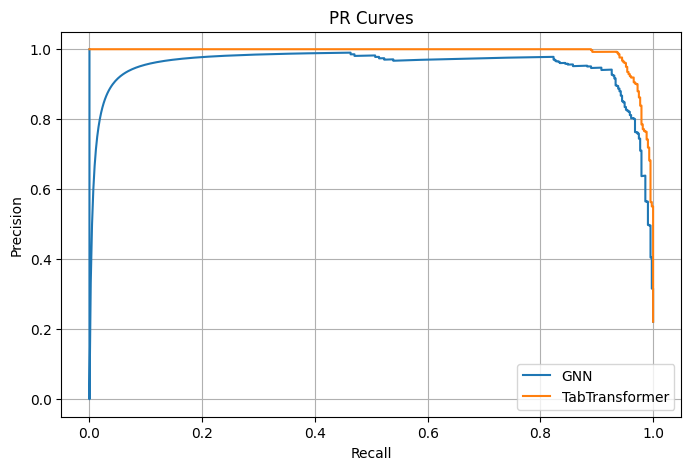

Done. Artifacts and models saved to ./artifacts


In [44]:
# 8) Compare & plots (basic)
try:
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_recall_curve
    model.eval()
    with torch.no_grad():
        gnn_probs = torch.sigmoid(model(x_nodes, edge_index)).cpu().numpy()[test_idx]
    pr_g, rc_g, _ = precision_recall_curve(y[test_idx], gnn_probs)
    pr_t, rc_t, _ = precision_recall_curve(ytrue, logits)
    plt.figure(figsize=(8,5))
    plt.plot(rc_g, pr_g, label='GNN')
    plt.plot(rc_t, pr_t, label='TabTransformer')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.title('PR Curves')
    plt.show()
except Exception as e:
    print('Plotting failed:', e)

print('Done. Artifacts and models saved to', ARTIFACTS_DIR)


In [45]:
print("Used features:", features)
print("Dropped categorical:", cat_drop)


Used features: ['Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val rec', ' ERC20 max 